In [ ]:
import py_gamma as pg
import cupy as cp
import numpy as np
from pathlib import Path
from path import read_Path
from geocode import rdc_width_nlines
import tempfile
from matplotlib import pyplot as plt
import colorcet
import pandas as pd

In [ ]:
rslc_dir = Path('/scratch/users/kangl/BarryArm/ALOS2/rslc')
rslcs = read_Path(rslc_dir,{'slc':'rslc','slc.par':'rslc.par'})
reference = '20210802'
hgt = Path('/scratch/users/kangl/BarryArm/ALOS2/geocoding/20210802.hgt')

In [ ]:
rslcs

slc  \
20210802  /scratch/users/kangl/BarryArm/ALOS2/rslc/20210...   
20210816  /scratch/users/kangl/BarryArm/ALOS2/rslc/20210...   
20210830  /scratch/users/kangl/BarryArm/ALOS2/rslc/20210...   
20210913  /scratch/users/kangl/BarryArm/ALOS2/rslc/20210...   
20211011  /scratch/users/kangl/BarryArm/ALOS2/rslc/20211...   
20211025  /scratch/users/kangl/BarryArm/ALOS2/rslc/20211...   
20220606  /scratch/users/kangl/BarryArm/ALOS2/rslc/20220...   
20220620  /scratch/users/kangl/BarryArm/ALOS2/rslc/20220...   
20220704  /scratch/users/kangl/BarryArm/ALOS2/rslc/20220...   
20220718  /scratch/users/kangl/BarryArm/ALOS2/rslc/20220...   
20220801  /scratch/users/kangl/BarryArm/ALOS2/rslc/20220...   
20220815  /scratch/users/kangl/BarryArm/ALOS2/rslc/20220...   
20220829  /scratch/users/kangl/BarryArm/ALOS2/rslc/20220...   
20220912  /scratch/users/kangl/BarryArm/ALOS2/rslc/20220...   
20220926  /scratch/users/kangl/BarryArm/ALOS2/rslc/20220...   
20221010  /scratch/users/kangl/BarryArm/ALOS2/rslc/20221...   
20221024  /scratch/users/kangl/BarryArm/ALOS2/rslc/20221...   

                                                    slc.par  
20210802  /scratch/users/kangl/BarryArm/ALOS2/rslc/20210...  
20210816  /scratch/users/kangl/BarryArm/ALOS2/rslc/20210...  
20210830  /scratch/users/kangl/BarryArm/ALOS2/rslc/20210...  
20210913  /scratch/users/kangl/BarryArm/ALOS2/rslc/20210...  
20211011  /scratch/users/kangl/BarryArm/ALOS2/rslc/20211...  
20211025  /scratch/users/kangl/BarryArm/ALOS2/rslc/20211...  
20220606  /scratch/users/kangl/BarryArm/ALOS2/rslc/20220...  
20220620  /scratch/users/kangl/BarryArm/ALOS2/rslc/20220...  
20220704  /scratch/users/kangl/BarryArm/ALOS2/rslc/20220...  
20220718  /scratch/users/kangl/BarryArm/ALOS2/rslc/20220...  
20220801  /scratch/users/kangl/BarryArm/ALOS2/rslc/20220...  
20220815  /scratch/users/kangl/BarryArm/ALOS2/rslc/20220...  
20220829  /scratch/users/kangl/BarryArm/ALOS2/rslc/20220...  
20220912  /scratch/users/kangl/BarryArm/ALOS2/rslc/20220...  
20220926  /scratch/users/kangl/BarryArm/ALOS2/rslc/20220...  
20221010  /scratch/users/kangl/BarryArm/ALOS2/rslc/20221...  
20221024  /scratch/users/kangl/BarryArm/ALOS2/rslc/20221...

In [ ]:
def flattenSLC(reference:str,
               rslcs:pd.DataFrame,
               hgt:Path,
               baseline_refine=False)->np.ndarray:
    ref_rslc = rslcs.loc[reference,'slc']
    ref_rslc_par = rslcs.loc[reference,'slc.par']
    n_image = len(rslcs)
    width,nlines = rdc_width_nlines(ref_rslc_par)
    rslc_data = np.empty((nlines,width,n_image),dtype=np.complex64)
    with tempfile.TemporaryDirectory() as temp_dir:
        temp_dir = Path(temp_dir)
        for i,(date,row) in enumerate(rslcs.iterrows()):
            off_par = temp_dir/(reference+'_'+date+'.off')
            pg.create_offset(ref_rslc_par,row['slc.par'],off_par,1,1,1,0)
            sim_orb = temp_dir/(reference+'_'+date+'.sim_orb')
            pg.phase_sim_orb(ref_rslc_par,row['slc.par'],off_par,hgt,sim_orb,ref_rslc_par,'-','-',1,1)
            one_rslc_data = pg.read_image(row['slc'],width=width,dtype='fcomplex')
            sim_unw_data = pg.read_image(sim_orb,width=width,dtype='float')
            rslc_data[:,:,i] = np.exp(sim_unw_data*np.complex64(1j))*one_rslc_data
    return rslc_data

The method behind the flattenSLC:

Let the value of i-th rslc be $s_i$, the simulated phase due to DEM and position difference be $u_{ij}$.
D-InSAR basically is:
$$d_{ij}=s_i \times s_j^* \times e^{-ju_{ij}}.$$
Let the distance between satellite and ground target for th i-th observation be $l_i$.
Then, the simulated phase for DInSAR
$$u_{ij} = l_i-l_j.$$
So, a simple conclusion is $$u_{ij}-u_{ik}=-u_{jk}.$$
If we define $$s_i^{\prime} = s_i \times e^{ju_{xi}},$$
where $X$ can be any arbitrary interger less than $N$- the total number of the RSLCs.
Then we can find that
$$int_{ij}^{\prime} =  s_i^{\prime} \times s_j^{\prime*} = s_i \times s_j^* \times e^{j(u_{xi}-u_{xj})} = s_i \times s_j^* \times e^{j(u_{xi}-u_{xj})} = s_i \times s_j^* \times e^{-ju_{ij}} = d_{ij}.$$

We call $s_i^{\prime}$ as flattened RSLC.
The advantage of flattened RSLC is DInSAR can be easily calculated by simple conjugate multiplication.

In [ ]:
rslc_data = flattenSLC(reference,rslcs,hgt)

*** Create and update ISP offset and interferogram parameter files ***
*** Copyright 2020 Gamma Remote Sensing v5.5 clw/uw/cm 21-Sep-2020 ***
SLC-1 title: ALOS2388461220-210802
SLC-1 Doppler centroid at center swath (Hz):    -38.041
SLC-1 number of range samples:             1834
SLC-1 number of image lines:               2500
SLC-1 slant range pixel spacing (m):   4.291267
SLC-1 azimuth sample spacing (m):      3.740103

SLC-2 title: ALOS2388461220-210802
SLC-2 Doppler centroid at center swath (Hz):    -38.041
SLC-2 number of range samples:             1834
SLC-2 number of lines:                     2500
SLC-2 slant range pixel spacing (m):   4.291267
SLC-2 azimuth sample spacing (m):      3.740103

OFFSET ALGORITHM: intensity cross-correlation
number of offset locations range: 32  azimuth: 64
patch size range: 64  azimuth: 64
offset correlation threshold: 0.100

Interferogram Parameters
************************
range looks:      1
azimuth looks:    1
range width pixels:   1834
azimut

In [ ]:
rslc_data.shape

(2500, 1834, 17)

In [ ]:
diff = rslc_data[:,:,12]*np.conjugate(rslc_data[:,:,16])

<matplotlib.colorbar.Colorbar>

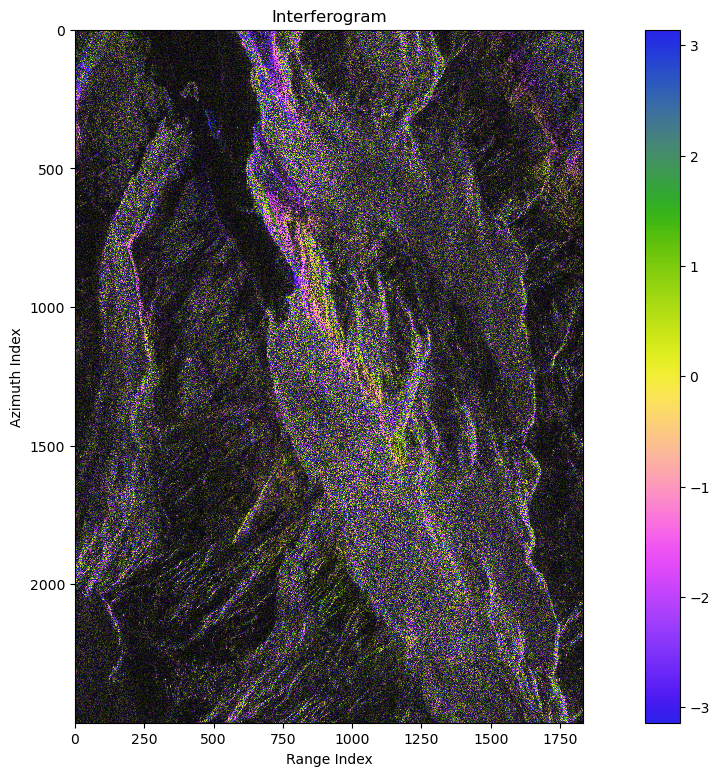

In [ ]:
alpha = bg_alpha(np.abs(rslc_data[:,:,0])**2)
fig,ax = plt.subplots(1,1,figsize=(16,9))
xlabel = 'Range Index'
ylabel = 'Azimuth Index'
pcm0 = ax.imshow(np.angle(diff),alpha=alpha,interpolation='nearest',cmap=cm)
# the real image showed is alpha*rgb + (1-alpha)*facecolor
ax.set(facecolor = "black")
ax.set(title='Interferogram',xlabel=xlabel,ylabel=ylabel)
fig.colorbar(pcm0,ax=ax)

The angle difference between this diff and diff generated with `mk_diff_2d` can reach to 0.1 (only test on multilooked images), who can explain it?
test done:
- even the same reference is selected, the difference can also reach 0.1.

In [ ]:
np.save('./rslc.npy',rslc_data)

## image_show

In [ ]:
def bg_alpha(pwr):
    _pwr = np.power(pwr,0.35)
    cv = _pwr.mean()*2.5
    v = (_pwr.clip(0., cv))/cv
    return v

In [ ]:
original_diff = pg.read_image('/home/kangl/scratch/BarryArm/ALOS2/diff_2_4/20220829_20221024.diff',width=917,dtype='fcomplex')
pwr = pg.read_image('/home/kangl/scratch/BarryArm/ALOS2/rmli_2_4/20220829.rmli',width=917,dtype='float')

image:
  width: 917  number of lines: 625
data read from image:
  column offset (x0): 0  row offset (y0): 0  
  width: 917  number of lines: 625
image:
  width: 917  number of lines: 625
data read from image:
  column offset (x0): 0  row offset (y0): 0  
  width: 917  number of lines: 625


<matplotlib.colorbar.Colorbar>

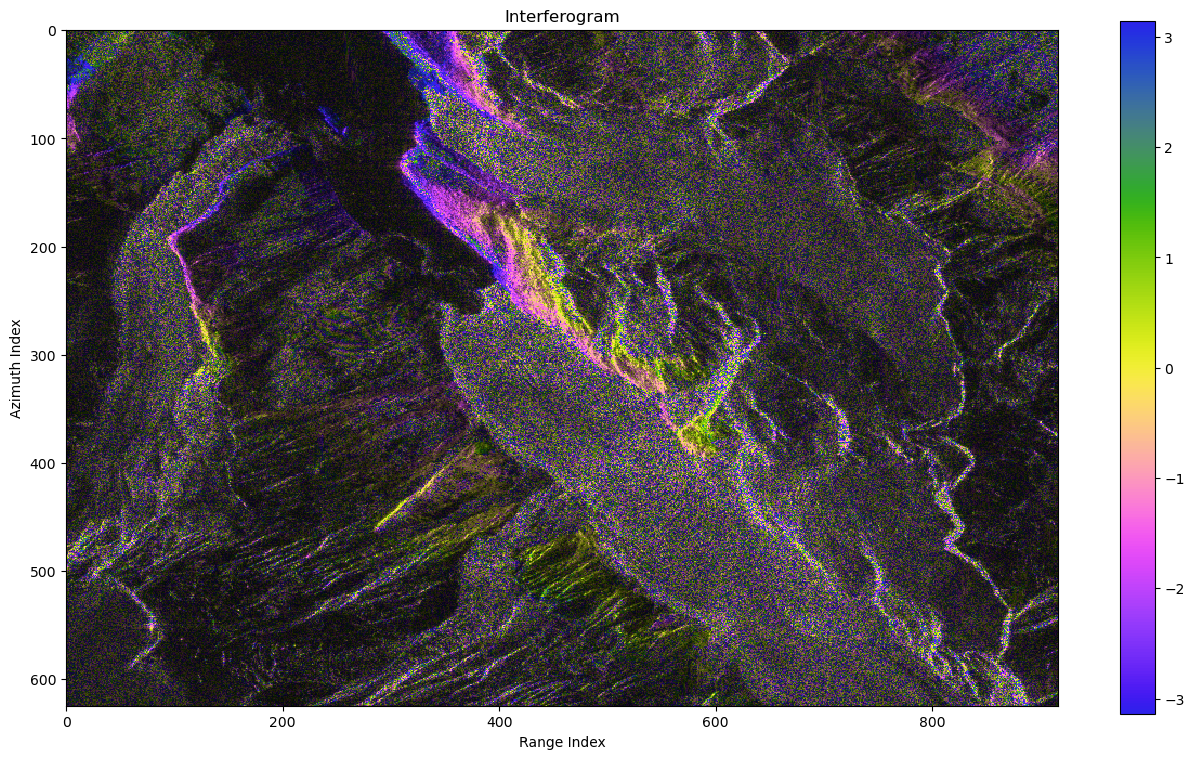

In [ ]:
alpha = bg_alpha(pwr)
fig,ax = plt.subplots(1,1,figsize=(16,9))
xlabel = 'Range Index'
ylabel = 'Azimuth Index'
# 对于存在噪声的数据，不要使用matplotlib默认的插值方式
pcm0 = ax.imshow(np.angle(original_diff),alpha=alpha,interpolation='nearest',cmap=cm)
# the real image showed is alpha*rgb + (1-alpha)*facecolor
ax.set(facecolor = "black")
ax.set(title='Interferogram',xlabel=xlabel,ylabel=ylabel)
fig.colorbar(pcm0,ax=ax)